# Load model, parameters, performance metrics

In [3]:
import os
import torch
import argparse
from models.vqvae import VQVAE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
import numpy as np

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
Utility functions
"""

def load_model(model_filename):
    path = os.getcwd() + '/results/'
    
    if torch.cuda.is_available():
        data = torch.load(path + model_filename)
    else:
        data = torch.load(path+model_filename,map_location=lambda storage, loc: storage)
    
    params = data["hyperparameters"]
    
    model = VQVAE(params['n_hiddens'], params['n_residual_hiddens'],
                  params['n_residual_layers'], params['n_embeddings'], 
                  params['embedding_dim'], params['beta']).to(device)

    model.load_state_dict(data['model'])
    
    return model, data

from scipy.signal import savgol_filter

def plot_metrics(data):
    results = data["results"]
    recon_errors = savgol_filter(results["recon_errors"], 19, 5)
    perplexities = savgol_filter(results["perplexities"], 19, 5)
    loss_vals = savgol_filter(results["loss_vals"], 19, 5)


    f = plt.figure(figsize=(16,4))
    ax = f.add_subplot(1,3,2)
    ax.plot(recon_errors)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,3)
    ax.plot(perplexities)
    ax.set_title('Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,1)
    ax.plot(loss_vals)
    ax.set_yscale('log')
    ax.set_title('Overall Loss')
    ax.set_xlabel('iteration')
    
def display_image_grid(x):
    x = make_grid(x.cpu().detach()+0.5)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
def reconstruct(data_loader,model):
    (x, _) = next(iter(data_loader))
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _,e_indices = model.vector_quantization(vq_encoder_output)
    
    x_recon = model.decoder(z_q)
    return x,x_recon, z_q,e_indices

"""
End of utilities
"""

model_filename = 'vqvae_data_june17run.pth'

model,vqvae_data = load_model(model_filename)


In [4]:
!ls results/

vqvae_data_1embeddings1edim.pth		 vqvae_data_block_embedding32.pth
vqvae_data_2embeddings1edim.pth		 vqvae_data_block_embedding64.pth
vqvae_data_2x2zdim2embeddings16edim.pth  vqvae_data_block_ne_16_eh_16.pth
vqvae_data_2x2zdim4embeddings16edim.pth  vqvae_data_june17run.pth
vqvae_data_4embeddings16edim.pth	 vqvae_data_thu_jun_6_16_56_26_2019.pth
vqvae_data_4embeddings1edim.pth		 vqvae_data_thu_jun_6_19_56_51_2019.pth


# Load dataset and loaders

In [5]:
import utils
training_data, validation_data, training_loader, validation_loader, x_train_var = utils.load_data_and_data_loaders('BLOCK', 32)

Loading block data
Done loading block data
Loading block data
Done loading block data


# Reconstruct validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


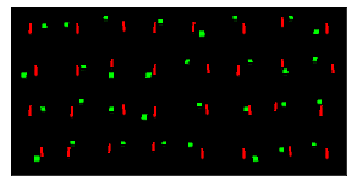

In [6]:
x_val,x_val_recon,z_q,e_indices = reconstruct(validation_loader,model)

display_image_grid(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


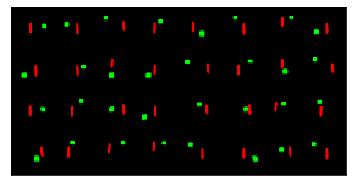

In [7]:
display_image_grid(x_val_recon)


# Smoothed Loss and Perplexity Values

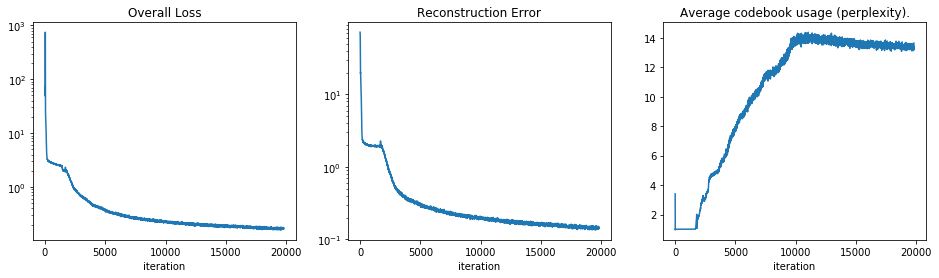

In [8]:
plot_metrics(vqvae_data)

# Sampling from latent space $z$

Sampling from VQ VAEs is more subtle than normal sampling schemes. To elucidate this point we'll present three sampling schemes:

1. Uniform sampling
2. Categorical sampling from a histogram 
3. Sampling with an autoregressive PixelCNN

Sampling scheme (1) produces scrambled results, because only a small percentage of all possible representations are actually utilized. If you sample uniformly, you will most likely get results outside of the data distribution, which is why they appear random.

Sampling scheme (2) collects a histogram of representations and samples from the histogram. This works but is also incorrect because it limits us to only representations seen during construction of the histogram. Note that if $N_{\text{histogram}} \rightarrow \infty $ then this scheme will work, but since we can't actually do this, we want a better way to approximate the disribution of our representation space.

Scheme (3) is more complex but provides a principled way of sampling from the latent space. We train a Gated PixelCNN to approximate the distribution of the latent space. 



In [9]:
params = vqvae_data['hyperparameters']

## Uniform sampling of latent space



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2048, 1])


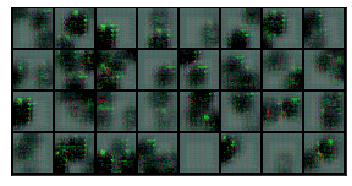

In [10]:
def generate_samples(e_indices):
    min_encodings = torch.zeros(e_indices.shape[0], params['n_embeddings']).to(device)
    min_encodings.scatter_(1, e_indices, 1)
    e_weights = model.vector_quantization.embedding.weight
    z_q = torch.matmul(min_encodings, e_weights).view((params["batch_size"],8,8,params["embedding_dim"])) 
    z_q = z_q.permute(0, 3, 1, 2).contiguous()
 
    x_recon = model.decoder(z_q)
    return x_recon, z_q,e_indices
    

def uniform_samples(model):
 
    rand = np.random.randint(params['n_embeddings'], size=(2048, 1))
    min_encoding_indices = torch.tensor(rand).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)
    
    print(min_encoding_indices.shape)
    return x_recon, z_q,e_indices

x_val_recon,z_q,e_indices = uniform_samples(model)

display_image_grid(x_val_recon)



## Categorial Distribution Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


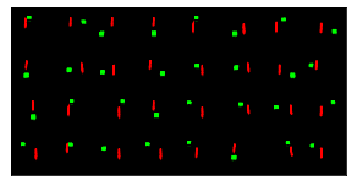

In [11]:
N = 100

    
def encode_observations():
    all_e_indices = []
    for i in range(N):
        _,_,_,e_indices = reconstruct(validation_loader,model)
        all_e_indices.append(e_indices)

    return torch.cat(all_e_indices)

e_indices = encode_observations()

def count_representations():
    d = {}
    for i in range(32*N):
        k = e_indices[64*i:64*i+64].squeeze().cpu().detach().numpy()
        k = [str(j)+'-' for j in k]
        k = ''.join(k)

        if k not in d:
            d[k] = 1
        else:
            d[k]+=1
    
    return d

hist = count_representations()

def sample_histogram(hist):
    keys, vals = np.array(list(hist.keys())),np.array(list(hist.values()))
    probs = np.array(vals)/sum(vals)
    samples = np.random.choice(keys,params['batch_size'],p=probs,replace=True)
    
    samples = np.array([np.array([int(y) for y in x.split('-')[:-1]]) for x in samples])
    
    return samples
    
samples = sample_histogram(hist)
    
def histogram_samples(model):
 
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)
    
    return x_recon, z_q,e_indices

x_hist,_,_ = histogram_samples(model)

display_image_grid(x_hist)


## The most common representation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1)


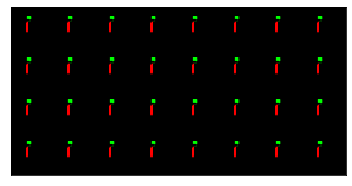

In [12]:
most_common_sample_index = np.argmax(list(hist.values()))
most_common_z = np.array([int(y) for y in list(hist.keys())[most_common_sample_index].split('-')[:-1]])


def most_common_samples(model):
    
    samples = np.array(list(most_common_z)*32).reshape(-1,1)
    print(samples.shape)
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)
    
    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = most_common_samples(model)

display_image_grid(x_val_recon)


# Reconstruct from PixelCNN

In [27]:
import os
data_folder_path = os.getcwd() 
data_file_path = data_folder_path + '/samples/latent_samples.npy'

samples = np.load(data_file_path,allow_pickle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


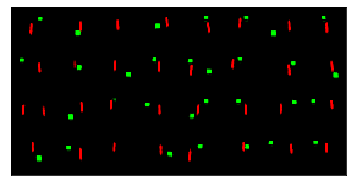

In [28]:
def reconstruct_from_pixelcnn(model,samples):
    

    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)
    
    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = reconstruct_from_pixelcnn(model,samples)

display_image_grid(x_val_recon)